# Session 6 : Feature extraction and selection

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This sixth session is dedicated to feature engineering and to feature selection. Slides are available at http://www.laurentoudre.fr/signalml.html

1. **Library and data loading**
2. **Exploratory study**
3. **Feature extraction**
4. **Unsupervised feature selection with PCA**
5. **Supervised feature selection**

## 1. Library and data loading

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

In [2]:
plt.rcParams['figure.figsize'] = (10,5)

In [3]:
# Data loading
npzfile = np.load('Session6.npz')
X1=npzfile['X1']
X2=npzfile['X2']
t=npzfile['t']
Fs=npzfile['Fs']

# First investigations
N,M=np.shape(X1)
print("Number of samples per signal : {N}".format(**locals()))
print("Number of signals per class : {M}".format(**locals()))

Number of samples per signal : 300
Number of signals per class : 100


## 2. Exploratory study

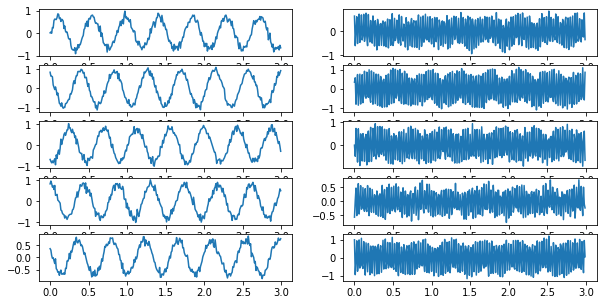

In [4]:
# Plot of the first 5 signals for each class
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.plot(t,X1[:,i])
    plt.subplot(5,2,2*i+2)
    plt.plot(t,X2[:,i])
plt.show()

## 3. Feature extraction

In [5]:
# Function to compute the relative energy in Nb frequency band
def relative_energy(x,Nb,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    f=np.fft.fftfreq(N, d=1/Fs)
    FNyq=Fs/2
    E=np.zeros((Nb,))
    for i in range(Nb):
        E[i]=np.sum(np.abs(X[(f>i*FNyq/Nb) & (f<=(i+1)*FNyq/Nb)])**2)
    E=E/np.sum(np.abs(X[(f>0) & (f<=Fs/2)])**2)
    return E

In [6]:
def compute_features(X):
    N,M=np.shape(X)
    Y=np.zeros((8,M))
    for i in range(M):
        Y[0,i]=np.mean(X[:,i])
        Y[1,i]=np.var(X[:,i])
        Y[2,i]=np.sqrt(np.sum(X[:,i]**2))
        E=relative_energy(X[:,i],5,1)
        Y[3:8,i]=E
    return Y

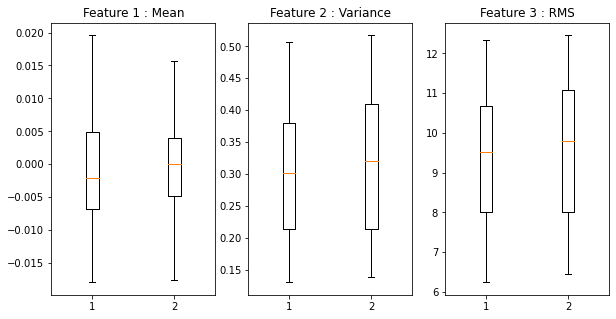

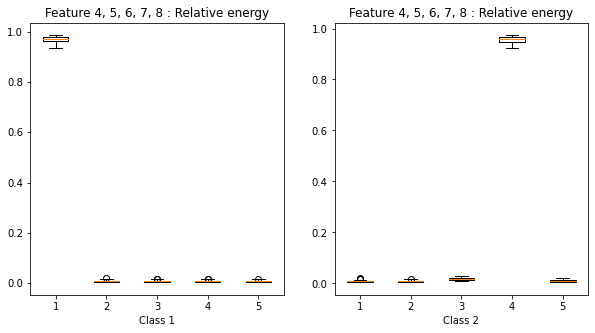

In [7]:
Y1=compute_features(X1)
Y2=compute_features(X2)

plt.figure()
plt.subplot(1,3,1)
plt.boxplot([Y1[0,:],Y2[0,:]])
plt.title("Feature 1 : Mean")
plt.subplot(1,3,2)
plt.boxplot([Y1[1,:],Y2[1,:]])
plt.title("Feature 2 : Variance")
plt.subplot(1,3,3)
plt.boxplot([Y1[2,:],Y2[2,:]])
plt.title("Feature 3 : RMS")



plt.figure()
plt.subplot(1,2,1)
plt.boxplot(np.transpose(Y1[3:8,:]))
plt.title("Feature 4, 5, 6, 7, 8 : Relative energy")
plt.xlabel('Class 1')
plt.subplot(1,2,2)
plt.boxplot(np.transpose(Y2[3:8,:]))
plt.title("Feature 4, 5, 6, 7, 8 : Relative energy")
plt.xlabel('Class 2')
plt.show()

## 4. Unsupervised feature selection with PCA

Given a data matrix $\mathbf{X}$ of size $D\times M$ ($D$ : number of features, $M$ : number of observations), the Principal Component Analysis (PCA) can be visualied with several steps:
1. Renormalization of the data matrix so that each row (i.e. features) is zero-mean and unit-variance
   $$\tilde{X}_{d,:} = \frac{ X_{d,:} - \mu_{X_{d,:}}}{\sigma_{X_{d,:}}}$$
2. Singular Value Decomposition (SVD) of $\tilde{\mathbf{X}}$:
   $$\tilde{\mathbf{X}} = \underbrace{\mathbf{U}}_{D\times D} \underbrace{\mathbf{S}}_{D\times M} \underbrace{\mathbf{V}^t}_{M \times M}$$
3. Plot of the contribution of each feature to the two first principal components on the correlation circle
   $$U_{d,j} : \mbox{ contribution of feature } d \mbox{ to the } j^{th} \mbox{ principal component}$$
 
Then, the features that contribute the most to the global data variance are those closest to the unit circle  

In [8]:
def my_pca(X):
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:])
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp

In [9]:
def plot_correlation_circle(U,feature_names,var_exp):
    D,D=np.shape(U)
    figure, axes = plt.subplots()
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')   
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()

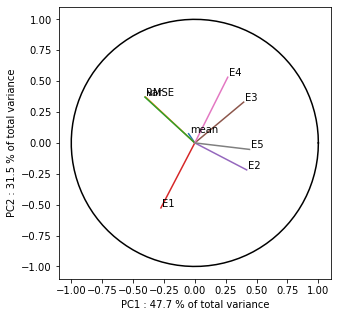

In [10]:
 # Computation of PCA
Y =np.concatenate((Y1,Y2),axis=1)
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

feature_names = [
  'mean',
  'var',
  'RMSE',
  'E1', 'E2', 'E3', 'E4','E5']
plot_correlation_circle(U,feature_names,var_exp)

In [11]:
# Norm computation for each feature
score=np.sqrt(U[:,0]**2+U[:,1]**2)
ind = np.argsort(score)
ind=ind[::-1]

for d in range(D):
    print("Feature ", feature_names[ind[d]], " : ",score[ind[d]])

Feature  E4  :  0.5947754290250161
Feature  E1  :  0.5934382348583369
Feature  RMSE  :  0.5483781848046705
Feature  var  :  0.5449446936012032
Feature  E3  :  0.5151131436801382
Feature  E2  :  0.4732540536902346
Feature  E5  :  0.4462037965609574
Feature  mean  :  0.08933711205802072


## 5. Supervised feature selection

Three main classes of methods:
* **Filter methods:** We test the adequacy of the feature with the annotations, thanks to several criterion/scores (e.g. correlation). 
* **Wrapper methods:** We test the features on a supervised classification task, by trying several combinations. The best features are kept.
* **Embedded methods:** Mixed approaches where we jointly infer the relevance of the features and classify the data (decision tree, sparse methods...) 
 
**Careful! Here we will use the whole database to perform feature selection, but in a real context we should only perform this on the train set**

In [12]:
# Annotations
M=100
y = np.concatenate((-1*np.ones((M,)),np.ones((M,))))

### 5.1 Filter methods

In [13]:
# Computes the Pearson correlation coefficient
def pearson_coefficient(x,y):
    N=np.size(x)
    x_=(x-np.mean(x))/np.std(x)
    y_=(y-np.mean(y))/np.std(y)
    c=np.dot(x_,y_)/N
    return c

In [14]:
# Computation, for each feature, of Pearson correlation coefficient between the data and the annotations
c=np.zeros((D,))
for d in range(D):
    c[d]=pearson_coefficient(Y[d,:],y)

print("Pearson correlation scores")
ind = np.argsort(np.abs(c))
ind=ind[::-1]
for d in range(D):
    print("Feature ", feature_names[ind[d]], " : ",c[ind[d]])

Pearson correlation scores
Feature  E1  :  -0.9998417249643842
Feature  E4  :  0.9998366476584917
Feature  E3  :  0.8122544105293802
Feature  E5  :  0.3900532738422905
Feature  E2  :  0.1361582876021623
Feature  var  :  0.07583466713800337
Feature  RMSE  :  0.07238598640606343
Feature  mean  :  0.02687499415049919


### 5.2 Wrapper methods

In [15]:
# Test of each feature on a classification task with a 1-Nearest Neighbor
M=200
neigh = KNeighborsClassifier(n_neighbors=1)
scores=np.zeros((D,))
for d in range(D):
    scores[d] = np.mean(cross_val_score(neigh, np.reshape(Y[d,:],(M,1)), y, cv=5))

print("Accuracy results with 1-NN (5-fold cross correlation)")
ind = np.argsort(scores)
ind=ind[::-1]
for d in range(D):
    print("Feature ", feature_names[ind[d]], " : ",scores[ind[d]])

Accuracy results with 1-NN (5-fold cross correlation)
Feature  E4  :  1.0
Feature  E1  :  1.0
Feature  E3  :  0.8899999999999999
Feature  E2  :  0.645
Feature  mean  :  0.5250000000000001
Feature  E5  :  0.5199999999999999
Feature  var  :  0.49499999999999994
Feature  RMSE  :  0.48999999999999994


### 5.3 Embedded methods

In [16]:
def renormalize(Y):
    D,M=np.shape(Y)
    Y_=np.zeros((D,M))
    for d in range(D):
        Y_[d,:]=(Y[d,:]-np.mean(Y[d,:]))/np.std(Y[d,:])
    return Y_

In [17]:
# Use of LASSO for the feature selection
Y_=renormalize(Y)
clf = linear_model.Lasso(alpha=0.9)
clf.fit(np.transpose(Y_),y)
coeff=clf.coef_

print("Contribution to the LASSO regression")
ind = np.argsort(np.abs(coeff))
ind=ind[::-1]
for d in range(D):
    print("Feature ", feature_names[ind[d]], " : ",coeff[ind[d]])

Contribution to the LASSO regression
Feature  E1  :  -0.09268245184357327
Feature  E4  :  0.007169740373202274
Feature  E5  :  0.0
Feature  E3  :  0.0
Feature  E2  :  0.0
Feature  RMSE  :  0.0
Feature  var  :  0.0
Feature  mean  :  0.0
